# download Data

In [ ]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xvf  'dakshina_dataset_v1.0.tar'

--2021-05-25 15:17:43--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   143MB/s    in 12s     

2021-05-25 15:17:55 (159 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.

# load data and process

In [ ]:
%pip install wandb -q
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 6.6MB/s 
     |████████████████████████████████| 174kB 26.0MB/s 
     |████████████████████████████████| 133kB 23.5MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 


In [ ]:
input_token_index = None
target_token_index = None
MAX_LEN_input = None
MAX_LEN_target = None
num_encoder_tokens = 30
num_decoder_tokens = 70
input_tokenizer = None
target_tokenizer = None

In [ ]:
def tokenize(data,vocab_size):
  tokenizer = Tokenizer(num_words=vocab_size,char_level=True)
  tokenizer.fit_on_texts(data)
  temp=tokenizer.texts_to_sequences(data)
  # print(data[:3])
  # print(temp[:3])
  dictionary = tokenizer.word_index
  return temp , dictionary , tokenizer

In [ ]:
def load_and_preprocess():
  global input_token_index , target_token_index , MAX_LEN_input , MAX_LEN_target ,num_decoder_tokens,num_encoder_tokens , input_tokenizer , target_tokenizer
  data_path = 'dakshina_dataset_v1.0/gu/lexicons/gu.translit.sampled.train.tsv'
  input_texts = []
  target_texts = []
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[:-1]:
    temp = line.split('\t')
    input_text, target_text = temp[1],temp[0] 
    target_text = "\t" + target_text + "\n"
    input_text = input_text+"\n"

    input_texts.append(input_text)
    target_texts.append(target_text)
  
  MAX_LEN_input = max([len(txt) for txt in input_texts])
  MAX_LEN_target = max([len(txt) for txt in target_texts])

  # toeknize
  encoder_input , input_token_index , input_tokenizer = tokenize(input_texts , num_encoder_tokens)
  decoder_input , target_token_index, target_tokenizer = tokenize(target_texts , num_decoder_tokens) 

  # padding
  encoder_input_data = pad_sequences(encoder_input, maxlen=MAX_LEN_input, dtype='int32', padding='post', truncating='post',value= input_token_index["\n"])
  decoder_input_data = pad_sequences(decoder_input, maxlen=MAX_LEN_target, dtype='int32', padding='post', truncating='post',value=target_token_index["\n"])

  decoder_target_data = np.zeros((len(input_texts), MAX_LEN_target, num_decoder_tokens), dtype="float32")
  for i,  target_text in enumerate(target_texts):
    for t, char in enumerate(target_text):
      if t > 0:
        decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_target_data[i, t:, target_token_index["\n"]] = 1.0

  return encoder_input_data , decoder_input_data, decoder_target_data

# load_and_preprocess()

In [ ]:
def load_val_data(data_path = 'dakshina_dataset_v1.0/gu/lexicons/gu.translit.sampled.dev.tsv'):
  global input_token_index , target_token_index , MAX_LEN_input , MAX_LEN_target ,num_decoder_tokens,num_encoder_tokens , input_tokenizer , target_tokenizer
  
  input_texts = []
  target_texts = []
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[:-1]:
    temp = line.split('\t')
    input_text, target_text = temp[1],temp[0] 
    target_text = "\t" + target_text + "\n"
    input_text = input_text+"\n"

    input_texts.append(input_text)
    target_texts.append(target_text)
  
  # tokenize
  encoder_input  = input_tokenizer.texts_to_sequences(input_texts)
  decoder_input  = target_tokenizer.texts_to_sequences(target_texts) 

  # padding
  encoder_input_data = pad_sequences(encoder_input, maxlen=MAX_LEN_input, dtype='int32', padding='post', truncating='post',value= input_token_index["\n"])
  decoder_input_data = pad_sequences(decoder_input, maxlen=MAX_LEN_target, dtype='int32', padding='post', truncating='post',value=target_token_index["\n"])

  decoder_target_data = np.zeros((len(input_texts), MAX_LEN_target, num_decoder_tokens), dtype="float32")
  for i,  target_text in enumerate(target_texts):
    for t, char in enumerate(target_text):
      if char == 'ૠ':
        char = 'ઋ'
      if t > 0:
        decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_target_data[i, t:, target_token_index["\n"]] = 1.0

  return encoder_input_data , decoder_input_data, decoder_target_data

# load_val_data()

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer, Concatenate
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,LSTM,Input,GRU,SimpleRNN,Dropout,Embedding

def create_model_attention(m_name="LSTM",n_e_layers=1,n_d_layers=1,latent_dim = 100,embedding_size = 16,dropout = 0 , recurrent_dropout = 0):
  global num_decoder_tokens,num_decoder_tokens
  keras.backend.clear_session()
  
  # Define an input sequence and process it.
  input1 = Input(shape=(None,),name= "input_1")
  encoder_inputs = Embedding(input_dim = num_encoder_tokens, output_dim = embedding_size)(input1)

  encoder = globals()[m_name](latent_dim,dropout=dropout,recurrent_dropout = recurrent_dropout, return_state=True,return_sequences=True)
  e_o = encoder(encoder_inputs)
  prev = e_o
  for i in range(1,n_e_layers):
    e = globals()[m_name](latent_dim, dropout=dropout,recurrent_dropout = recurrent_dropout,return_state=True,return_sequences=True)
    e_o = e(prev[0])
    prev = e_o
  
  input2 = Input(shape=(None,),name="input_2")
  decoder_inputs = Embedding(input_dim = num_decoder_tokens, output_dim = embedding_size)(input2)
  d_l = globals()[m_name](latent_dim,dropout=dropout,recurrent_dropout = recurrent_dropout, return_sequences=True, return_state=True)(decoder_inputs,initial_state = e_o[1:])
  p_d = d_l[0]
  for i in range(1,n_d_layers):
    d_l = globals()[m_name](latent_dim,dropout=dropout,recurrent_dropout = recurrent_dropout, return_state=True, return_sequences=True)(p_d,initial_state = e_o[1:])
    p_d = d_l[0]

  attn_layer = AttentionLayer(name="attention_layer")
  attn_op, attn_state = attn_layer([e_o[0], d_l[0]])
  decoder_concat_input = Concatenate(axis=-1)([d_l[0], attn_op])


  dec_dense = Dense(num_decoder_tokens, activation='softmax')
  final_output = dec_dense(decoder_concat_input)
 

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = keras.Model([input1,input2], final_output)

  return model


# sweep

In [ ]:
def train_attention():
  run = wandb.init()
  c = run.config
  name = "model_"+c.model+"_o_"+c.optimizer+"_hs_"+str(c.hidden_size)+"_em_"+str(c.embedding_size)+"_d_"+str(c.dropout)+"_bs_"+str(c.batch_size)
  run.name = name
  print(name)
  batch_size = c.batch_size
  epochs = 20

  # used single encoder and decoder layer
  encoder_layers , decoder_layers = 1 , 1


  encoder_input_data,decoder_input_data ,decoder_target_data = load_and_preprocess()
  val_encoder_input_data,val_decoder_input_data ,val_decoder_target_data = load_val_data()

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

  model = create_model_attention(c.model,encoder_layers,decoder_layers,c.hidden_size,c.embedding_size,c.dropout,0)
  model.compile(optimizer=c.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data),
    # validation_split=0.2,
    callbacks=[WandbCallback(),es]
  )
  
  temp = model.predict([val_encoder_input_data, val_decoder_input_data]).argmax(axis=-1)
  val_word_acc = sum((temp[:,:-1] == val_decoder_input_data[:,1:]).all(axis=-1)) / len(val_encoder_input_data)
  # print(val_word_acc)

  temp = model.predict([encoder_input_data,decoder_input_data]).argmax(axis=-1)
  train_word_acc = sum((temp[:,:-1] == decoder_input_data[:,1:]).all(axis=-1)) / len(encoder_input_data)
  # print(train_word_acc)

  wandb.log({"val_word_acc" : round(val_word_acc,4) , "train_word_acc" : round(train_word_acc,4)})
  return

In [ ]:
sweep_config_attention={
    'method' : 'random' ,
    'metric' : { 'name' : 'val_word_acc' , 'goal' : 'maximize' } ,
    'parameters' : {
        'model' : { 'values' : ['LSTM','GRU','SimpleRNN'] },
        'dropout' : { 'values' : [0.1,0.2,0.3]},
        'embedding_size' : {'values' : [32,64,128]},
        'hidden_size' : {'values' : [128,256,512]},
        'batch_size' : {'values' : [64,128]},
        'optimizer' : {'values' : ['rmsprop' ,'adam']}
    }
}


In [ ]:

sweepid = wandb.sweep(sweep_config_attention,project="DL_A3_Q5_final",entity ="sonagara")
wandb.agent(sweepid,train_attention)

Create sweep with ID: 8azc26kw
Sweep URL: https://wandb.ai/sonagara/DL_A3_Q5_testing1/sweeps/8azc26kw


wandb: Agent Starting Run: bo9mqqa0 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	embedding_size: 128
wandb: 	hidden_size: 512
wandb: 	model: SimpleRNN
wandb: 	optimizer: adam


model_SimpleRNN_o_adam_hs_512_em_128_d_0.2_bs_128
  2/823 [..............................] - ETA: 34:05 - loss: 4.0117 - accuracy: 0.1678  

wandb: Ctrl + C detected. Stopping sweep.


#  best model

## train best model

In [ ]:
def train_best():
  m_name = "LSTM"
  encoder_layers = 1
  decoder_layers = 1
  latent_dim = 128
  embedding_size = 32
  dropout = 0.3
  batch_size = 64
  recurrent_dropout = 0  # 0 to use cudnnlstm which is faster than lstm
  optimizer = "adam"

  encoder_input_data,decoder_input_data ,decoder_target_data = load_and_preprocess()
  val_encoder_input_data,val_decoder_input_data ,val_decoder_target_data = load_val_data()
  

  model = create_model_attention(m_name,encoder_layers,decoder_layers,latent_dim,embedding_size,dropout,recurrent_dropout)
  # model = keras.models.load_model("s2s")
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

  model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=20,
    # validation_split = 0.2,
    validation_data=([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data),
    callbacks=[es]
  )

  temp = model.predict([val_encoder_input_data, val_decoder_input_data]).argmax(axis=-1)
  val_word_acc = sum((temp[:,:-1] == val_decoder_input_data[:,1:]).all(axis=-1)) / len(val_encoder_input_data)
  print(val_word_acc)

  temp = model.predict([encoder_input_data,decoder_input_data]).argmax(axis=-1)
  train_word_acc = sum((temp[:,:-1] == decoder_input_data[:,1:]).all(axis=-1)) / len(encoder_input_data)
  print(train_word_acc)
  


  # Save model
  model.save("s2sa")
  # print(test_acc("LSTM",100,1,2))
train_best()

Epoch 1/20
1645/1645 [==============================] - 311s 186ms/step - loss: 1.2458 - accuracy: 0.7059 - val_loss: 0.7247 - val_accuracy: 0.7950
Epoch 2/20
1645/1645 [==============================] - 307s 187ms/step - loss: 0.5707 - accuracy: 0.8341 - val_loss: 0.2032 - val_accuracy: 0.9323
Epoch 3/20
1645/1645 [==============================] - 304s 185ms/step - loss: 0.2056 - accuracy: 0.9327 - val_loss: 0.1692 - val_accuracy: 0.9423
Epoch 4/20
1645/1645 [==============================] - 309s 188ms/step - loss: 0.1640 - accuracy: 0.9451 - val_loss: 0.1544 - val_accuracy: 0.9464
Epoch 5/20
1645/1645 [==============================] - 306s 186ms/step - loss: 0.1425 - accuracy: 0.9516 - val_loss: 0.1470 - val_accuracy: 0.9504
Epoch 6/20
1645/1645 [==============================] - 312s 190ms/step - loss: 0.1306 - accuracy: 0.9559 - val_loss: 0.1407 - val_accuracy: 0.9525
Epoch 7/20
1645/1645 [==============================] - 316s 192ms/step - loss: 0.1183 - accuracy: 0.9601 - val_

INFO:tensorflow:Assets written to: s2sa/assets


INFO:tensorflow:Assets written to: s2sa/assets


## run inference

In [ ]:
import re
def load_test_data():
  global input_token_index , MAX_LEN_input , num_encoder_tokens , input_tokenizer
  data_path = 'dakshina_dataset_v1.0/gu/lexicons/gu.translit.sampled.test.tsv'
  input_texts=[]
  target_texts = []
  s = r'ૠ'
  # input_characters = set()
  with open(data_path,"r",encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[:-1]:
    temp = line.split("\t")
    input_text , target_text = temp[1] ,temp[0]
    target_text = re.sub(s,'ઋ',target_text)
    input_text = input_text + "\n"
    target_text = target_text + "\n"
    
    input_texts.append(input_text)
    target_texts.append(target_text)
  
  encoder_input = input_tokenizer.texts_to_sequences(input_texts)
  encoder_input_data = pad_sequences(encoder_input, maxlen=MAX_LEN_input, dtype='int32', padding='post', truncating='post',value= input_token_index["\n"])
  print(encoder_input_data.shape)
  
  return encoder_input_data ,input_texts, target_texts
# load_test_data()

In [ ]:
def enc_dec_attention(m_name="LSTM",n_e_layers=1,n_d_layers=1,latent_dim = 100):
  model = keras.models.load_model("s2sa")
 
  if (n_e_layers == 1):
    l_name = ""
  else:
    l_name = "_"+str(n_e_layers-1)

  if (m_name == "SimpleRNN"):
    n_name = "simple_rnn"
  else:
    n_name = m_name
  # model.summary()

  # encoder
  encoder_inputs = model.input[0]
  encoder_outputs, *encoder_states = model.get_layer(n_name.lower()+l_name).output  # last encoding layer
  encoder_model = tf.keras.models.Model(encoder_inputs, [encoder_outputs,encoder_states])
  # encoder_model.summary()
    

  # decoder
  decoder_inputs = model.input[1]
  decoder_embed = model.get_layer("embedding_1")(decoder_inputs)
  decoder_states_inputs = []
  decoder_states_inputs.append(keras.Input(shape=(latent_dim,)))
  if (m_name == "LSTM"):
    decoder_states_inputs.append(keras.Input(shape=(latent_dim,)))
  decoder_outputs, *decoder_states = model.get_layer(n_name.lower()+"_"+str(n_e_layers))(decoder_embed, initial_state=decoder_states_inputs)
  decoder_model = tf.keras.models.Model([decoder_inputs, decoder_states_inputs],[decoder_outputs] + decoder_states)
  # decoder_model.summary()

  atten_layer = model.get_layer("attention_layer")
  dense_layer = model.get_layer("dense")

  return encoder_model , decoder_model ,atten_layer ,dense_layer 

# enc_dec_attention()

In [ ]:

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence_attention(input_seq,encoder_model,decoder_model,decoder_dense,atten_layer):
    global num_decoder_tokens , target_token_index , reverse_target_char_index , MAX_LEN_target
    # Encode the input as state vectors.

    enc_op, states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    attn_state_arr = []
    while not stop_condition:
        dec_outputs, states* = decoder_model.predict([target_seq , states_value])

        atten_op, attn_state = atten_layer([enc_op, dec_outputs])
        attn_state_arr.append(attn_state)
        # print(attn_state)
        decoder_concat_input = Concatenate(axis=-1)([dec_outputs, atten_op])
        decoder_concat_input = decoder_dense(decoder_concat_input)
        
        sampled_token_index = np.argmax( decoder_concat_input[0, -1, :] )
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        # print(decoded_sentence)
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > MAX_LEN_target:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = target_token_index[sampled_char]

        # Update states
        states_value = states

    return decoded_sentence , attn_state_arr


In [ ]:
decode_results = []
test_input = None
def test_acc_attention(m_name="LSTM" ,latent_dim = 100, n_e_layers = 1,n_d_layers = 1):
  global decode_results ,test_input
  x_test ,x ,y_test = load_test_data()
  test_input = x
  enc ,dec  , atten , dense = enc_dec_attention(m_name , n_e_layers ,n_d_layers, latent_dim)
  score = 0 
  print(len(y_test))

  for seq_index in range(len(y_test)):
    
    input_seq = x_test[seq_index : seq_index + 1]
    decoded_sentence , _ = decode_sequence_attention(input_seq,enc,dec,dense,atten)
    decode_results.append(decoded_sentence)
    if (y_test[seq_index] == decoded_sentence):
      score += 1
    # print("-")
    # print("Input sentence:", y_test[seq_index])
    # print("Decoded sentence:", decoded_sentence)
  print(score/len(y_test))
  return score/len(y_test)
test_acc_attention("LSTM" , 128,1,1)

In [ ]:
import pandas as pd
def save_csv():
  global test_input , decode_results
  dict = {"Input Sentence" : test_input[:len(decode_results)] , "Decoded Sentence" : decode_results}
  df = pd.DataFrame(dict)
  df.to_csv("predictions_attention.csv")
save_csv()

## plot attention

In [ ]:
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansGujarati-hinted.zip'
!unzip 'NotoSansGujarati-hinted.zip'
!mv 'NotoSansGujarati-Regular.ttf' '/usr/share/fonts/truetype/'


--2021-05-25 16:31:37--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansGujarati-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352058 (344K) [application/zip]
Saving to: ‘NotoSansGujarati-hinted.zip’

NotoSansGujarati-hi 100%[===================>] 343.81K  --.-KB/s    in 0.005s  

2021-05-25 16:31:37 (73.1 MB/s) - ‘NotoSansGujarati-hinted.zip’ saved [352058/352058]

Archive:  NotoSansGujarati-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansGujarati-Bold.ttf  
  inflating: NotoSansGujarati-Regular.ttf  
  inflating: NotoSansGujaratiUI-Bold.ttf  
  inflating: NotoSansGujaratiUI-Regular.ttf  
  inflating: README                  


(10373, 23)


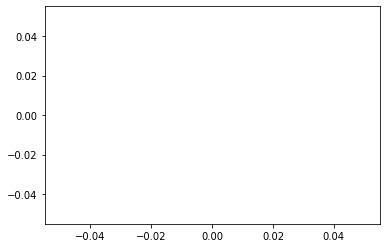

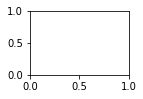

In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
# path = '/usr/share/fonts/truetype/NotoSansGujarati-Regular.ttf'
# fontprop = fm.FontProperties(fname=path, size= 15)

# mpl.font_manager.fontManager.addfont('NotoSansGujarati-Regular.ttf')
# # fm.fontManager.ttflist += fm.createFontList(['NotoSansGujarati-Regular.ttf'])
# matplotlib.rc('font', family='Noto Sans Gujarati')
# mlp.rcParams['font.sans-serif']=['Noto Sans Gujarati'] #Show Chinese label
# mlp.rcParams['axes.unicode_minus']=False  
def attention_heat_map(m_name="LSTM", latent_dim =100 ,n_e_layers = 1 ,n_d_layers = 1):
  x_test , x ,y_test = load_test_data()
  enc ,dec  , atten , dense = enc_dec_attention(m_name,n_e_layers ,n_d_layers, latent_dim)
  score = 0 
  # print(len(y_test))
  plt.plot(figsize = (12,12))
  fig, ax = plt.subplots()
  for seq_index in range(1):
    input_seq = x_test[seq_index : seq_index + 1]
    decoded_sentence , attn_states = decode_sequence_attention(input_seq,enc,dec,dense,atten)
    decoded_sentence = decoded_sentence 
    c_names = list(x[seq_index])
    i_names = list(decoded_sentence)
    # print(i_names,c_names)
    temp = np.shape(attn_states)
    # print(temp)
    attn_states = np.reshape(attn_states,(temp[0],temp[-1]))[:,:len(c_names)]
    # print(np.shape(attn_states))
    # df_cm = pd.DataFrame(attn_states, index=i_names, columns=c_names)
    # df_cm.index =df_cm.index.str.encode('utf-32')
    #
    plt.subplot(3,3,seq_index+1)
    # sn.set(font_scale=1.4)
    # sn.set(font = 'Noto Sans Gujarati')
    # sn.heatmap(attn_states,cmap='rocket_r')
    # plt.set_xticks

    ax.imshow(attn_states , cmap = 'rocket_r')
    # plt.set_xticks(np.arange(len(c_names)))
    # plt.set_yticks(np.arange(len(i_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(c_names)
    ax.set_yticklabels(i_names)
    
    # plt.xticks(c_names)
    # plt.xlabel(c_names)
    # plt.ylabel(i_names)
    # plt.show()
  # plt.savefig('confmatrix.png', dpi=600,bbox_inches='tight')
  return 
attention_heat_map("LSTM",128,1,1)

In [ ]:
from matplotlib import font_manager

font_paths = font_manager.findSystemFonts()
print(font_paths)
font_objects = font_manager.createFontList(font_paths)
font_names = [f.name for f in font_objects]
print(font_names)

['/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/NotoSansGujarati-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


In [ ]:
import matplotlib
import matplotlib.font_manager as fm

# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansGujarati-hinted.zip'
!unzip 'NotoSansGujarati-hinted.zip'

mpl.font_manager.fontManager.addfont('NotoSansGujarati-Regular.ttf')
# fm.fontManager.ttflist += fm.createFontList(['NotoSansGujarati-Regular.ttf'])
matplotlib.rc('font', family='Noto Sans Gujarati')

--2021-05-20 11:21:04--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansGujarati-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.250.128.128, 2607:f8b0:4001:c32::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352058 (344K) [application/zip]
Saving to: ‘NotoSansGujarati-hinted.zip.4’

NotoSansGujarati-hi 100%[===================>] 343.81K  --.-KB/s    in 0.003s  

2021-05-20 11:21:04 (111 MB/s) - ‘NotoSansGujarati-hinted.zip.4’ saved [352058/352058]

Archive:  NotoSansGujarati-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansGujarati-Bold.ttf  
  inflating: NotoSansGujarati-Regular.ttf  
  inflating: NotoSansGujaratiUI-Bold.ttf  
  inflating: NotoSansGujaratiUI-Regular.ttf  
  inflating: README    

NameError: ignored

# visualization

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import re

# Imports for visualisations
from IPython.display import HTML as html_print
from IPython.display import display
import keras.backend as K

In [ ]:
# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
  colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
  l = len(colors)
  value = int((value * 100) / 5)
  if (value >= l):
    value = l-1
  
  return colors[value]



In [ ]:
from google.colab import output
import time
def visualize(m_name="LSTM", latent_dim =100 ,n_e_layers = 1 ,n_d_layers = 1):
  x_test , x ,y_test = load_test_data()
  enc ,dec  , atten , dense = enc_dec_attention(m_name,n_e_layers ,n_d_layers, latent_dim)
  
  # print(len(y_test)) 65 71 104
  for seq_index in range(71,72):
    input_seq = x_test[seq_index : seq_index + 1]
    decoded_sentence , attn_states = decode_sequence_attention(input_seq,enc,dec,dense,atten)
    # print(len(x[seq_index]),len(decoded_sentence))
    # print(np.shape(attn_states))
    temp = np.shape(attn_states)
    attn_states =  np.array(attn_states).reshape((temp[0],temp[-1]))[:-1,:len(x[seq_index])-1]
    # print(attn_states)
    
    # print(np.shape(attn_states))
    
    for j in range(len(attn_states)):
      text_color = [(x[seq_index][i],get_clr(attn_states[j][i])) for i in range(len(x[seq_index])-1)]
      output.clear()
      print(decoded_sentence[j])
      print_color(text_color)
      time.sleep(1.5)
      # output.clear()

  return 
visualize("LSTM",128,1,1)

ર
